In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function, absolute_import

import time

import GPy
import matplotlib.pyplot as plt
import numpy as np

from grid_world import (compute_true_safe_set, compute_S_hat0,
                                compute_true_S_hat, draw_gp_sample, GridWorld)

In [3]:
# Define world
world_shape = (10, 10)
step_size = (0.5, 0.5)

In [4]:
# Define GP
noise = 0.001
kernel = GPy.kern.RBF(input_dim=2, lengthscale=(2., 2.), variance=1.,
                      ARD=True)
lik = GPy.likelihoods.Gaussian(variance=noise ** 2)
lik.constrain_bounded(1e-6, 10000.)

reconstraining parameters Gaussian_noise


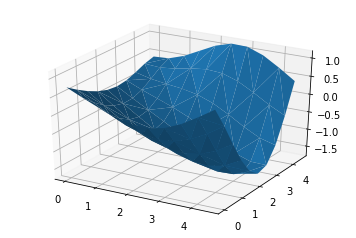

In [5]:
# Sample and plot world
altitudes, coord = draw_gp_sample(kernel, world_shape, step_size)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(coord[:, 0], coord[:, 1], altitudes)
plt.show()

In [6]:
# Define coordinates
n, m = world_shape
step1, step2 = step_size
xx, yy = np.meshgrid(np.linspace(0, (n - 1) * step1, n),
                     np.linspace(0, (m - 1) * step2, m),
                     indexing="ij")
coord = np.vstack((xx.flatten(), yy.flatten())).T

In [7]:
# Safety threhsold
h = -0.25

# Lipschitz
L = 0

# Scaling factor for confidence interval
beta = 2

In [8]:
# Data to initialize GP
n_samples = 1
ind = np.random.choice(range(altitudes.size), n_samples)
X = coord[ind, :]
Y = altitudes[ind].reshape(n_samples, 1) + np.random.randn(n_samples,
                                                           1)
gp = GPy.core.GP(X, Y, kernel, lik)

In [9]:
# Initialize safe sets
S0 = np.zeros((np.prod(world_shape), 5), dtype=bool)
S0[:, 0] = True
S_hat0 = compute_S_hat0(np.nan, world_shape, 4, altitudes,
                        step_size, h)

No valid initial seed starting from this state
No valid initial seed starting from this state
No valid initial seed starting from this state


In [10]:
# Define SafeMDP object
x = GridWorld(gp, world_shape, step_size, beta, altitudes, h, S0, S_hat0, L)

I have added edges


In [ ]:
# Insert samples from (s, a) in S_hat0
tmp = np.arange(x.coord.shape[0])
s_vec_ind = np.random.choice(tmp[np.any(x.S_hat[:, 1:], axis=1)])
tmp = np.arange(1, x.S.shape[1])
actions = tmp[x.S_hat[s_vec_ind, 1:].squeeze()]
for i in range(3):
    x.add_observation(s_vec_ind, np.random.choice(actions))

In [ ]:
# Remove samples used for GP initialization
x.gp.set_XY(x.gp.X[n_samples:, :], x.gp.Y[n_samples:])

t = time.time()
for i in range(100):
    x.update_sets()
    next_sample = x.target_sample()
    x.add_observation(*next_sample)
    # x.compute_graph_lazy()
    # plt.figure(1)
    # plt.clf()
    # nx.draw_networkx(x.graph)
    # plt.show()
    print("Iteration:   " + str(i))

In [ ]:
true_S = compute_true_safe_set(x.world_shape, x.altitudes, x.h)
true_S_hat = compute_true_S_hat(x.graph, true_S, x.initial_nodes)

# Plot safe sets
x.plot_S(x.S_hat)
x.plot_S(true_S_hat)

# Classification performance
print(np.sum(np.logical_and(true_S_hat, np.logical_not(
    x.S_hat))))  # in true S_hat and not S_hat
print(np.sum(np.logical_and(x.S_hat, np.logical_not(true_S_hat))))


In [ ]:
new_grid_world = GridWorld(gp, (3, 3), step_size, beta, altitudes, h, S0, S_hat0, L)